TODOs
[] show cl format?
[] read first couple blocks again
[] note about bin centers if cov_hs_g_ell_bin_average is True

# Spaceborne demo notebook
This notebook shows how to use `Spaceborne` to compute photometric covariance matrices, and then how to load and unpack them for subsequent analyses. Please keep in mind that more in-depth information about the different settings and the code in general can be found, respectively, in the [example configuration file](https://github.com/davidesciotti/Spaceborne/blob/main/config.yaml) and in the official [documentation](https://spaceborne.readthedocs.io/en/latest/?badge=latest)

## Inputs
To begin with, let's import the necessary libraries, define the paths to the input files, and show the format that the code expects for the input data.
In general, besides the settings defined in the configuration file, the user needs to provide as external inputs:

* **The source and/or lens redshift distributions**. These are required to compute radial kernels and $C_\ell$. Even when using input $C_\ell$, the redshift distributions are still needed to project the SSC and cNG trispectra; in short, they are mandatory in the following cases:
    * when using internally-generated $C_\ell$ (aka, `cfg['C_ell']['use_input_cls'] = False`)
    * if the SSC and/or cNG covariance contributions are required (i.e., `cfg['covariance']['SSC'] = True` and/or `cfg['covariance']['cNG'] = True`) 

In [149]:
import os
import pprint
import subprocess

import matplotlib.pyplot as plt
import numpy as np
import yaml
from scipy.integrate import simpson

from spaceborne import wf_cl_lib
from spaceborne import plot_lib as sb_plt
from spaceborne import sb_lib as sl


In [150]:
io_path = None

In [151]:
if io_path is None:
    io_path = '../Spaceborne_demo_IO'
    os.makedirs(io_path, exist_ok=True)

### Construct a mock redshift distribution
For demonstration purposes, we can construct a mock redshift distribution using the Smail et al. (1994) functional form and convolving it with Gaussian photo-z uncertainties. For this, we follow the recipe proposed in the Euclid Red Book [1110.3193] and the IST:F paper [1910.09273], from which we take the parameters of the p_ph function. \
Here we choose equidistant bins for simplicity.

In [152]:
zmin = 1e-3
zmax = 2.5
zsteps = 1_000
zbins = 3

z_edges = np.linspace(zmin, zmax, zbins + 1)
z_grid = np.linspace(zmin, zmax, zsteps)

colors = plt.cm.rainbow(np.linspace(0, 1, zbins))

In [153]:
pph_kw = {
    'c_in': 1.0,
    'z_in': 0.0,
    'sigma_in': 0.05,
    'c_out': 1.0,
    'z_out': 0.1,
    'sigma_out': 0.05,
    'f_out': 0.1,
}
z_m = 0.9
z_0 = z_m / np.sqrt(2)
n_gal = 30

In [154]:
nz = wf_cl_lib.nz_smail(z_grid, z_0=z_0, n_gal=n_gal)
nz_i = np.zeros((zsteps, zbins))
for zi in range(zbins):
    z_lo = z_edges[zi]
    z_hi = z_edges[zi + 1]

    nz_i[:, zi] = wf_cl_lib.convolve_nz_with_p_ph(
        nz, z_lo, z_hi, z_grid, pph_kw, zp_steps=500, normalize=False
    )


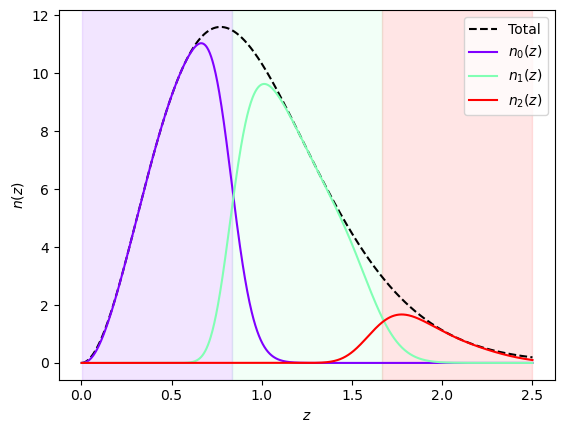

In [155]:
plt.plot(z_grid, nz, c='k', label='Total', ls='--')
for zi in range(zbins):
    plt.axvspan(z_edges[zi], z_edges[zi + 1], color=colors[zi], alpha=0.1)
    plt.plot(z_grid, nz_i[:, zi], c=colors[zi], label=f'$n_{zi}(z)$')
plt.xlabel('$z$')
plt.ylabel('$n(z)$')
plt.legend()

Save the redshift distributions in the `Spaceborne` format. For this, we create an IO folder just outside the repository path (or wherever you indicated).\
In its simplest incarnation (fits is available as well) the $n_i(z)$ file format, as described in the documentation and in the `yaml` config file, is simply a 2D array with the first column containing the redshift grid and following columns containing the redshift distributions for each tomographic bin. 

In [156]:
if io_path is None:
    io_path = '../Spaceborne_demo_IO'
    os.makedirs(io_path, exist_ok=True)

# create input/output subfolders
os.makedirs(f'{io_path}/input', exist_ok=True)
os.makedirs(f'{io_path}/output', exist_ok=True)

nz_tab = np.column_stack((z_grid, nz_i))
np.savetxt(f'{io_path}/input/nz_demo.txt', nz_tab)

Great! Another important ingredient is the number of galaxies per arcmin^2 in each tomographic bin, which is needed to compute the shape noise contribution to the covariance. The list below can be copied and pasted in the `yaml` config file.

In [157]:
ngal_i = simpson(y=nz_i, x=z_grid, axis=0)
print('Number of galaxies per arcmin^2 in each tomographic bin:')
print(ngal_i)

Number of galaxies per arcmin^2 in each tomographic bin:
[5.76805815 5.96900451 0.91842631]


Another input which can be passed to Spaceborne is a user-provided ell binning scheme. Let's quickly show the format:

In [158]:
ell_min, ell_max, ell_bins = 10, 3000, 30

ells_edges = np.geomspace(ell_min, ell_max, ell_bins + 1)
ells = np.sqrt(ells_edges[:-1] * ells_edges[1:])
delta_ells = ells_edges[1:] - ells_edges[:-1]

ell_tab = np.column_stack((ells, delta_ells, ells_edges[:-1], ells_edges[1:]))

np.savetxt(f'{io_path}/input/ells_demo.txt', ell_tab)

Next, let's turn to galaxy bias. The code has a baked-in `polynomial_fit` option, which allows to play with a simple polynomial redshift dependence of the form 

$$b(z) = c_0 + c_1 z + c_2 z^2 + c_3 z^3$$

where the coefficients $c_i$ are user-defined (they are the values in the `galaxy_bias_fit_coeff` list).

For more general forms, a table with the same format as the n(z), i.e., a 2D array with the first column containing the redshift grid and following columns containing the bias for each tomographic bin, can be provided (see `gal_bias_table_filename`). The code will then perform an interpolation to evaluate the bias at the redshifts needed for the computations. Let's construct this table for the simple case of a top-hat constant bias in each tomographic bin, for example. We'll take as reference values the simple form $b(z) = \sqrt{1+z}$

**Note**: the exact same applies for magnification bias, if needed.


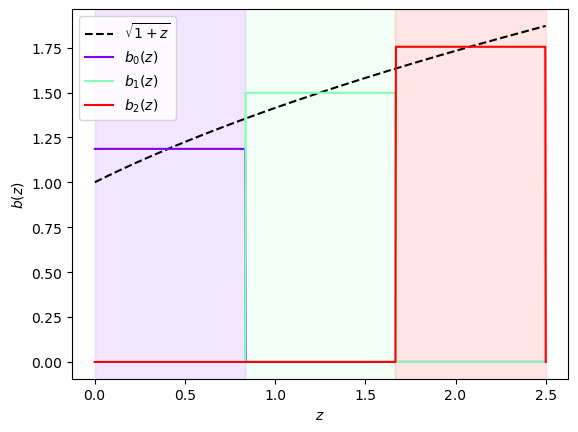

In [159]:
bz = np.sqrt(1 + z_grid)

bz_i = np.zeros((zsteps, zbins))
for zi in range(zbins):
    z_lo = z_edges[zi]
    z_hi = z_edges[zi + 1]
    mask = (z_grid >= z_lo) & (z_grid < z_hi)
    bz_i[mask, zi] = np.mean(bz[mask])

plt.plot(z_grid, bz, c='k', label='$\sqrt{1+z}$', ls='--')
for zi in range(zbins):
    plt.axvspan(z_edges[zi], z_edges[zi + 1], color=colors[zi], alpha=0.1)
    plt.plot(z_grid, bz_i[:, zi], c=colors[zi], label=f'$b_{zi}(z)$')
plt.xlabel('$z$')
plt.ylabel('$b(z)$')
plt.legend()

np.savetxt(f'{io_path}/input/gal_bias_demo.txt', np.column_stack((z_grid, bz_i)))

Excellent! That's it for the inputs (unless you want to provide your own $C_\ell$ as well, which is also possible as we'll see in a moment). 

### Running the code

Next, let's see how to run the code.

First, we need to construct the configuration yaml file. This can be done:
* manually, by editing the existing `config.yaml` file in the root of the repository, and then running the code with `python main.py`
* manually, by creating a new yaml file (say, `my_config.yaml`) and then running the code with `python main.py --config=path/to/my_config.yaml`
* programmatically, by creating a dictionary with the same structure as the `yaml` file, saving it as a new `yaml` file, and then launching `Spaceborne` with something like `subprocess.run` (see below for an example of how to do this).

There is no substantial difference between these approaches, but the latter allows to interface `Spaceborne` with other codes and pipelines more easily. 

In this demo we'll use this approach; to save time, we will not build a new config dictionary from scratch, but rather import the existing `config.yaml` file, modify the relevant entries, and save it back as a new file. \
⚠️ This obviously exposes the user to the risk of forgetting to update some of the configurations with respect to the config file we are importing, but for the sake of this demo it is faster. If an additional layer of control over the input settings is desired, you can instead create the config dictionary from scratch, in which case the code will raise an informative error if some config has not been set.

Let's load the `config.yaml` file and inspect its content: 

In [160]:
with open('./config.yaml') as f:
    cfg = yaml.safe_load(f)

pprint.pprint(cfg)

{'BNT': {'cl_BNT_transform': False, 'cov_BNT_transform': False},
 'C_ell': {'cl_CCL_kwargs': {'l_limber': -1,
                             'limber_integration_method': 'spline',
                             'non_limber_integration_method': 'FKEM'},
           'cl_GG_filename': '/data/sciotti/DATA/Spaceborne_jobs/develop/input/cl_gg.txt',
           'cl_GL_filename': '/data/sciotti/DATA/Spaceborne_jobs/develop/input/cl_gl.txt',
           'cl_LL_filename': '/data/sciotti/DATA/Spaceborne_jobs/develop/input/cl_ll.txt',
           'gal_bias_table_filename': '/data/sciotti/DATA/Spaceborne_jobs/develop/input/gal_bias.txt',
           'galaxy_bias_fit_coeff': [1.33291, -0.72414, 1.0183, -0.14913],
           'has_IA': True,
           'has_magnification_bias': True,
           'has_rsd': False,
           'mag_bias_table_filename': '/data/sciotti/DATA/Spaceborne_jobs/develop/input/mag_bias.txt',
           'magnification_bias_fit_coeff': [-1.50685,
                                            

Now that the configuration has been loaded into the `cfg` dictionary, we can update the paths of the newly created inputs

In [161]:
# If you encounter any issues, you can try using absolute paths
# io_abs_path = os.path.abspath(io_path)

# otherwise, keep path as is
io_abs_path = io_path

# assume the same n(z) for lenses and sources for simplicity
cfg['nz']['nz_lenses_filename'] = f'{io_abs_path}/input/nz_demo.txt'
cfg['nz']['nz_sources_filename'] = f'{io_abs_path}/input/nz_demo.txt'

# arrays create issues when using yaml.dump(). use lists instead
cfg['nz']['ngal_lenses'] = ngal_i.tolist()
cfg['nz']['ngal_sources'] = ngal_i.tolist()

# make sure that the galaxy bias is read from the input file, and specify
# the path to the file
cfg['C_ell']['which_gal_bias'] = 'from_input'
cfg['C_ell']['gal_bias_table_filename'] = f'{io_abs_path}/input/gal_bias_demo.txt'

# make sure that the ell binning is read from the input file, and specify
# the path to the file
cfg['binning']['binning_type'] = 'from_input'
cfg['binning']['ell_bins_filename'] = f'{io_abs_path}/input/ells_demo.txt'

# make sure to save "full" (6D) cov, to plot Cls with error bars below
cfg['covariance']['save_full_cov'] = True

# make sure non-Gaussian covariance is not computed to save some time
cfg['covariance']['SSC'] = False
cfg['covariance']['cNG'] = False


# we also need to set the output folder for the results
cfg['misc']['output_path'] = f'{io_abs_path}/output'

Now save back the updated dictionary to a `config_demo.yaml` file:

In [162]:
with open(f'{io_path}/config_demo.yaml', 'w') as f:
    yaml.dump(cfg, f)


Spaceborne must be run from the command line, so we'll use the `!` operator to run it from the notebook. 
This can be done with the magic `!` operator, which allows to run shell commands directly from the notebook.

```bash
!python main.py --config config.yaml
```

more in general, we can use the `subprocess` module to run the code from within Python. This is more flexible and allows to capture the output, errors, etc. For example: 


In [163]:
subprocess.run(
    ['python', 'main.py', '--config', f'{io_abs_path}/config_demo.yaml'], check=True
)

JAX devices: [CpuDevice(id=0)]
JAX backend: cpu
         Capping at 14 to prevent thread oversubscription
   _____                       __                        
  / ___/____  ____ _________  / /_  ____  _________  ___ 
  \__ \/ __ \/ __ `/ ___/ _ \/ __ \/ __ \/ ___/ __ \/ _ \
 ___/ / /_/ / /_/ / /__/  __/ /_/ / /_/ / /  / / / /  __/
/____/ .___/\__,_/\___/\___/_.___/\____/_/  /_/ /_/\___/ 
    /_/                                                  


Generating a polar cap mask with area 13245 deg^2 and nside 1024
Angular radius of the cap: 69.0309 deg
fsky = 0.3211
survey_area_sr = 4.0354
survey_area_deg2 = 13247.4109

Checking n(z) normalization...


sys:1: UserWarning: 
The lens n(z) are not normalized within atol=0, rtol=1e-3. Proceeding to normalize them
sys:1: UserWarning: 
The source n(z) are not normalized within atol=0, rtol=1e-3. Proceeding to normalize them



Computing Cls...
...done in 1.17 s

Computing Gaussian harmonic-space covariance matrix...
...done in 0.11 s

Skipping SSC computation

Skipping cNG computation

Covariance matrices saved in ../Spaceborne_demo_IO/output

Figures saved in ../Spaceborne_demo_IO/output/figs

Finished in 0.09 minutes


CompletedProcess(args=['python', 'main.py', '--config', '../Spaceborne_demo_IO/config_demo.yaml'], returncode=0)

## Outputs

Great! We successfully ran Spaceborne from another code. Let's now inspect the outputs and understand the 'O' part of the 'IO' folder. 

As a first step, let's load the internally-generated $C(\ell)$; their `.txt` format is a 2D table with the first column containing the $\ell$ value, the second column containing the first redshift bin index, the third column containing the second redshift bin index, and the fourth column containing the $C_\ell$ value. you can use the functions in `sb_lib` to read these tables and reshape them into 3D arrays with dimensions (ell, zbins, zbins), which is the format that the code uses internally.

In [164]:
cl_ll_3d = sl.read_cl_tab(f'{io_path}/output', 'cl_ll.txt', ells, zbins)
cl_gl_3d = sl.read_cl_tab(f'{io_path}/output', 'cl_gl.txt', ells, zbins)
cl_gg_3d = sl.read_cl_tab(f'{io_path}/output', 'cl_gg.txt', ells, zbins)

# to save them, you can use the sl.write_cl_tab function

Plot the $C_\ell$ for a quick check (nevermind the dictionaries in the call to `cls_triangle_plot`):

(<Figure size 700x700 with 9 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >]], dtype=object))

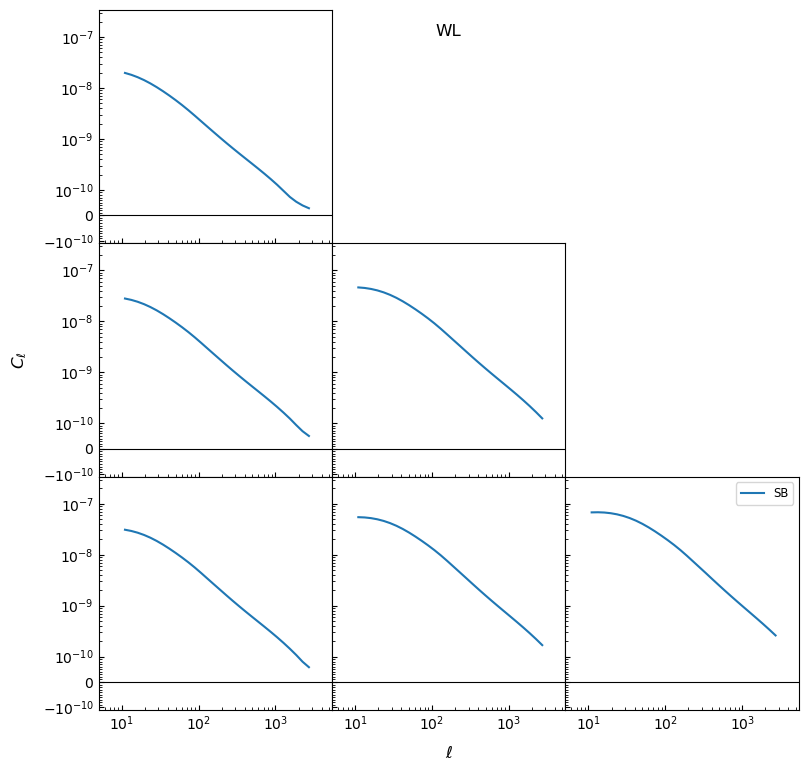

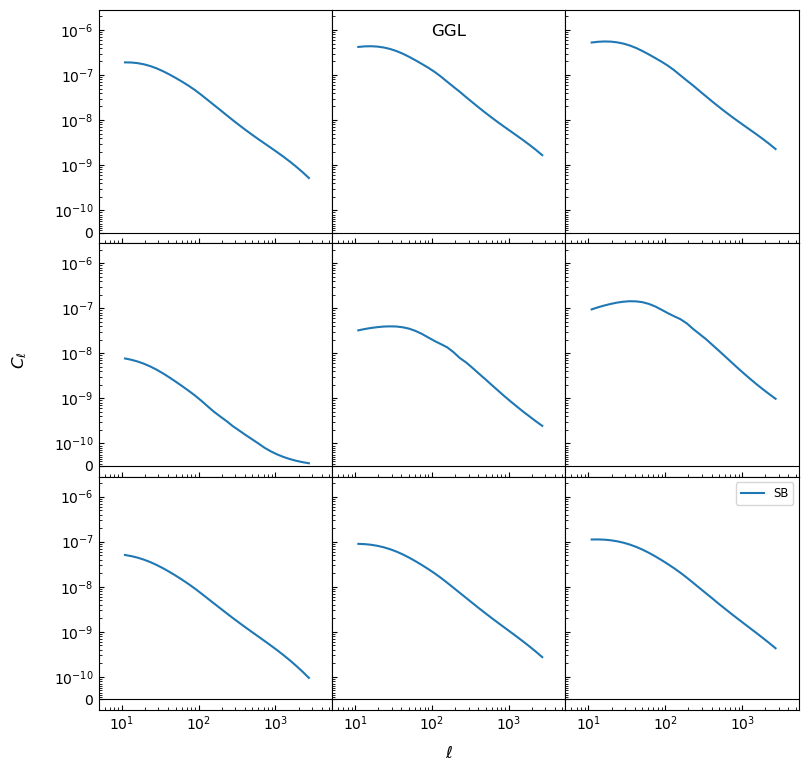

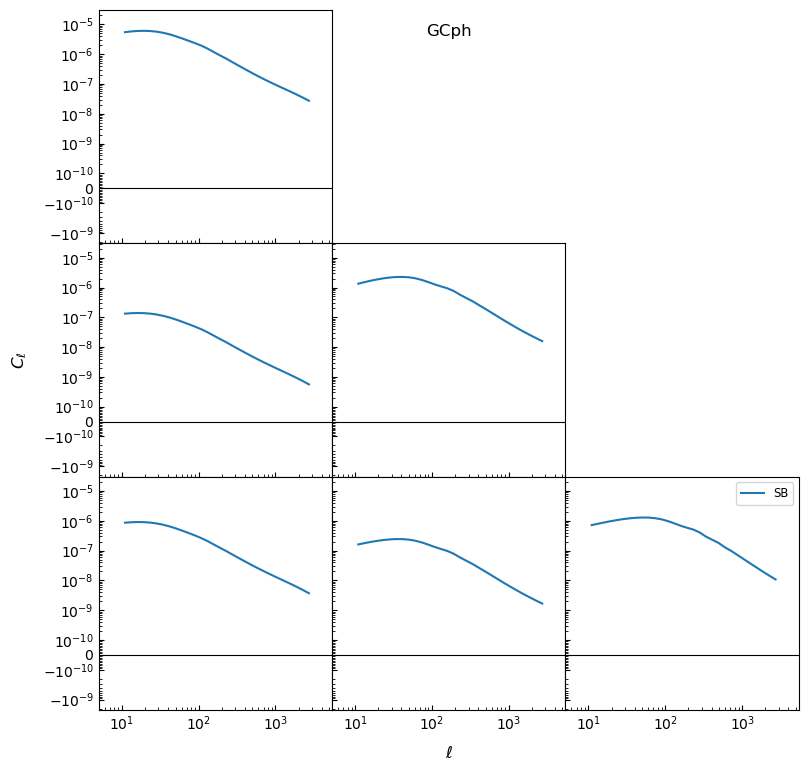

In [165]:
sb_plt.cls_triangle_plot(
    {'SB': ells}, {'SB': cl_ll_3d}, is_auto=True, zbins=zbins, suptitle='WL'
)
sb_plt.cls_triangle_plot(
    {'SB': ells}, {'SB': cl_gl_3d}, is_auto=False, zbins=zbins, suptitle='GGL'
)
sb_plt.cls_triangle_plot(
    {'SB': ells}, {'SB': cl_gg_3d}, is_auto=True, zbins=zbins, suptitle='GCph'
)

We've almost arrived at the fun part, the covariance matrix. The code saves them in a compressed `.npz` format, with a numpy array for each covariance term (Gauss, SSC, cNG; and SVA, SN and MIX if we requested to split the Gaussian covariance part):

In [166]:
covs_2d = np.load(f'{io_path}/output/covmat_2D.npz')
covs_2d.files

['Gauss', 'SVA', 'SN', 'MIX']

Plot the Gaussian covariance and its corresponding correlation matrix:

/var/folders/dp/8cyfcrf94f7c57dqdtt0gx4w0000gn/T/ipykernel_12904/1696526471.py:4: RuntimeWarning: divide by zero encountered in log10
  ax[0].matshow(np.log10(cov))


Text(0.5, 1.0, 'Correlation')

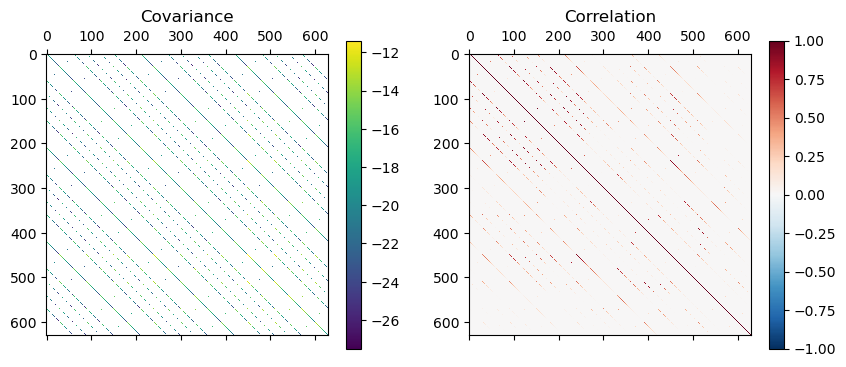

In [167]:
cov = covs_2d['Gauss']

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].matshow(np.log10(cov))
ax[1].matshow(sl.cov2corr(cov), vmin=-1, vmax=1, cmap='RdBu_r')
plt.colorbar(ax[0].images[0], ax=ax[0], shrink=0.8)
plt.colorbar(ax[1].images[0], ax=ax[1], shrink=0.8)
ax[0].set_title('Covariance')
ax[1].set_title('Correlation')

This is nice, but what if we want to isolate the covariance for a given probe, or tomographic combination, e.g. to plot error bars? Here's where the "full" covariance format comes in handy: as before it it contains arrays for all the different covariance terms, but this time the arrays are firther split into the different probe combinations (LL, GL, GG in the harmonic-space case), and they have 6 dimensions: (ell_bins, ell_bins, zbins, zbins, zbins, zbins):

In [168]:
covs_6d = np.load(f'{io_path}/output/covmat_6D.npz')
covs_6d.files

['LLLL_Gauss',
 'LLLL_SVA',
 'LLLL_SN',
 'LLLL_MIX',
 'LLGL_Gauss',
 'LLGL_SVA',
 'LLGL_SN',
 'LLGL_MIX',
 'LLGG_Gauss',
 'LLGG_SVA',
 'LLGG_SN',
 'LLGG_MIX',
 'GLGL_Gauss',
 'GLGL_SVA',
 'GLGL_SN',
 'GLGL_MIX',
 'GLGG_Gauss',
 'GLGG_SVA',
 'GLGG_SN',
 'GLGG_MIX',
 'GGGG_Gauss',
 'GGGG_SVA',
 'GGGG_SN',
 'GGGG_MIX']

In [169]:
print(
    'Shape of the shear-shear Gaussian covariance in 6D:', covs_6d['LLLL_Gauss'].shape
)

Shape of the shear-shear Gaussian covariance in 6D: (30, 30, 3, 3, 3, 3)


Now we can easily isolate the parts of the covariance matrix we are interested in. For example, let's add Gaussian error bars to the $C_\ell$ plot we made before:

(<Figure size 700x700 with 9 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >]], dtype=object))

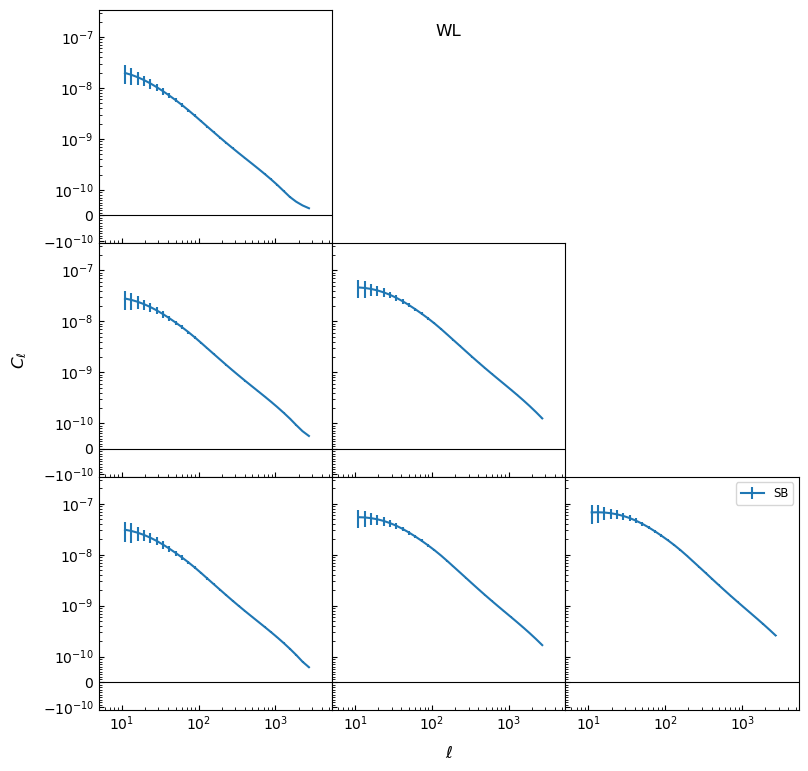

In [170]:
sb_plt.cls_triangle_plot(
    {'SB': ells},
    {'SB': cl_ll_3d},
    is_auto=True,
    zbins=zbins,
    suptitle='WL',
    cov_6d=covs_6d['LLLL_Gauss'],
)

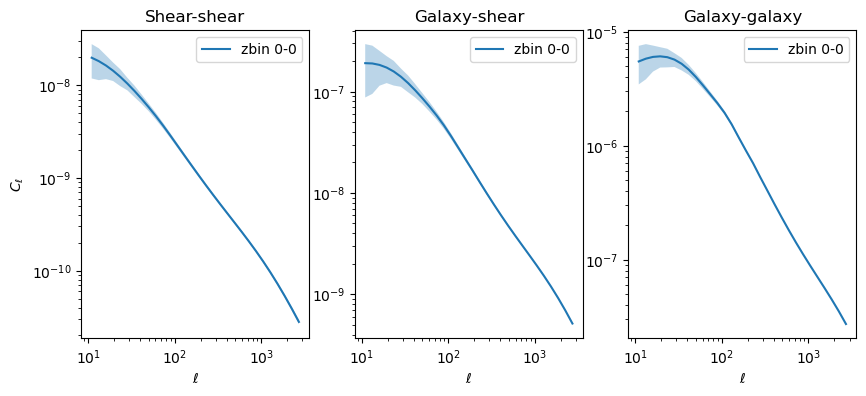

In [171]:
# or, more explicitly:
zi, zj = 0, 0

fig, ax = plt.subplots(1, 3, figsize=(10, 4))

err_ll = np.sqrt(covs_6d['LLLL_Gauss'][:, :, zi, zj, zi, zj].diagonal())
err_gl = np.sqrt(covs_6d['GLGL_Gauss'][:, :, zi, zj, zi, zj].diagonal())
err_gg = np.sqrt(covs_6d['GGGG_Gauss'][:, :, zi, zj, zi, zj].diagonal())

ax[0].plot(ells, cl_ll_3d[:, zi, zj], label=f'zbin {zi}-{zj}')
ax[0].fill_between(
    ells, cl_ll_3d[:, zi, zj] - err_ll, cl_ll_3d[:, zi, zj] + err_ll, alpha=0.3
)
ax[1].plot(ells, cl_gl_3d[:, zi, zj], label=f'zbin {zi}-{zj}')
ax[1].fill_between(
    ells, cl_gl_3d[:, zi, zj] - err_gl, cl_gl_3d[:, zi, zj] + err_gl, alpha=0.3
)
ax[2].plot(ells, cl_gg_3d[:, zi, zj], label=f'zbin {zi}-{zj}')
ax[2].fill_between(
    ells, cl_gg_3d[:, zi, zj] - err_gg, cl_gg_3d[:, zi, zj] + err_gg, alpha=0.3
)

ax[0].set_title('Shear-shear')
ax[1].set_title('Galaxy-shear')
ax[2].set_title('Galaxy-galaxy')

ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
    
ax[0].set_ylabel('$C_\ell$')
ax[0].set_xlabel('$\ell$')
ax[1].set_xlabel('$\ell$')
ax[2].set_xlabel('$\ell$')
ax[0].legend()
ax[1].legend()
ax[2].legend()